In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
pip install tensorflow==2.0

# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [0]:
# Build the model

class MyModel(Model):
  
  def __init__(self):
    super(MyModel, self).__init__()
    self.dense_1 = Dense(64, activation='relu')
    self.dense_2 = Dense(10)
    self.dropout = Dropout(0.4)

  def call(self, inputs, training=True):
    x = self.dense_1(inputs)
    if training:
      x = self.dropout(x)
    return self.dense_2(x)

# define a model subclass denoted as MyModel
# The objects that you will generate from this class are models with two dense layers. Then within the init method, 
# you can define the two dense layers.
# in the call method, you can set up the forward pass by calling the previously defined dense layers.
# Firstly you can place the Dense 1 layer to take the inputs
# after it, the Dense 2 layer that returns the outputs of the layer.

# Now go back and modify the call method by including a keyword argument called training.
# This is useful if you want to have different behavior in training and in inference.
# For example, for this, you can create a dropout layer that will be activated only if training is true

In [4]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([1,10]))
model.summary()

# The next step is to instantiate the model. 
# For this, just call the class without any argument inside the brackets.
# Next, call the model on a random input to create the weights.
# For the input, I guess using a one-dimensional vector with 10 elements.
# After, you can print out model.summary, where you can see the dense layers that you defined before.

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  704       
_________________________________________________________________
dense_1 (Dense)              multiple                  650       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Build the model

class MyModel(Model):
  
  def __init__(self):
    super(MyModel, self).__init__()
    self.dense_1 = Dense(64, activation='relu')
    self.dense_2 = Dense(10)
    self.dense_3 = Dense(5)
    self.softmax = Softmax()

  def call(self, inputs):
    x = self.dense_1(inputs)
    y1 = self.dense_2(inputs)
    y2 = self.dense_3(y1)
    concat = concatenate([x, y2])
    return self.softmax(concat)

# you can experiment with concatenating the outputs of two layers.
# This is useful if you want to define us obtain non-linear topology in the model.
# add a third dense layer of five units together with a softmax layer to the init method.
# You can create two branches by playing with the layers in the network.
# One branch has only the dense one layer, the other has the dense two, a dense three layers sequentially.
# Then the outputs of both branches can be concatenated by just writing concatenate.
# At the end, you can set up a softmax layer for the output of the concatenation.

In [6]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([1,10]))
model.summary()

Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  704       
_________________________________________________________________
dense_3 (Dense)              multiple                  110       
_________________________________________________________________
dense_4 (Dense)              multiple                  55        
_________________________________________________________________
softmax (Softmax)            multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [8]:
# Create a custom layer

class MyLayer(Layer):

  def __init__(self, units, input_dim):
    super(MyLayer, self).__init__()
    self.w = self.add_weight(shape = (input_dim, units),
                             initializer = 'random_normal')
    self.b = self.add_weight(shape = (units,),
                             initializer = 'zeros')
    
    def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3, 5)
x = tf.ones((1, 5))
print(dense_layer(x))
print(dense_layer.weights)

tf.Tensor([[1. 1. 1. 1. 1.]], shape=(1, 5), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.04238772, -0.01499842,  0.03144122],
       [-0.00376119,  0.01006788,  0.00616314],
       [-0.00847362,  0.03943233, -0.02595833],
       [ 0.02076507, -0.05136209,  0.00939988],
       [-0.02356167,  0.01731388,  0.08058437]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [0]:
# Specify trainable weights

class MyLayer(Layer):

  def __init__(self, units, input_dim):
    super(MyLayer, self).__init__()
    self.w = self.add_weight(shape = (input_dim, units),
                             initializer = 'random_normal',
                             trainable=False)
    self.b = self.add_weight(shape = (units,),
                             initializer = 'zeros',
                             trainable=False)
    
    def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3, 5)

In [10]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 0
non-trainable weights: 2


In [0]:
# Create a custom layer to accumulate means of output values

class MyLayerMean(Layer):

  def __init__(self, units, input_dim):
    super(MyLayerMean, self).__init__()
    self.w = self.add_weight(shape = (input_dim, units),
                             initializer = 'random_normal')
    self.b = self.add_weight(shape = (units,),
                             initializer = 'zeros')
    self.sum_activation = tf.Variable(initial_value=tf.zeros((units,)),
                                      trainable=False)
    self.number_call = tf.Variable(initial_value=0,
                                   trainable=False)
    
    def call(self, inputs):
      activations = tf.matmul(inputs, self.w) + self.b
      self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
      self.number_call.assign_add(inputs.shape[0])
      return activations, self.sum_activation / tf.cast(self.number_call, tf.float32)

dense_layer = MyLayerMean(3, 5)

In [0]:
# Test the layer

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

In [0]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

#### Implement the custom layers into a model

In [0]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)

        return self.softmax(x)

In [15]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[3.8417117e-04 7.0363408e-06 7.0363408e-06 ... 7.0363408e-06
  7.0363408e-06 7.0363408e-06]], shape=(1, 10000), dtype=float32)
Model: "my_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_2 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout (MyDropout)       multiple                  0         
_________________________________________________________________
my_layer_3 (MyLayer)         multiple                  4160      
_________________________________________________________________
my_dropout_1 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_4 (MyLayer)         multiple                  2990      
_________________________________________________________________
softmax_1 (Softmax)          multiple            

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [0]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

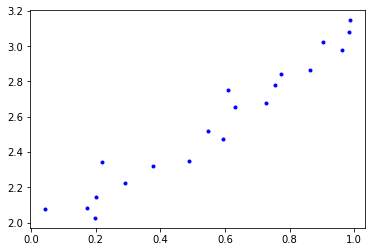

In [17]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [0]:
from tensorflow.keras.layers import Layer

In [19]:
# Build a custom layer for the linear regression model

class LinearLayer(Layer):
  
  def __init__(self):
    super(LinearLayer, self).__init__()
    self.m = self.add_weight(shape=(1,),
                             initializer = 'random_normal')
    self.b = self.add_weight(shape=(1,),
                             initializer = 'zeros')
    
  def call(self, inputs):
    return self.m*inputs+self.b

linear_regression = LinearLayer()

print(linear_regression(x_train))
print(linear_regression.weights)

tf.Tensor(
[0.0589023  0.05523419 0.01786437 0.04614269 0.06023839 0.02309819
 0.04452568 0.02998605 0.03347091 0.01241871 0.04737506 0.05283008
 0.01349668 0.03857351 0.01064908 0.03635269 0.00274625 0.012217
 0.03741079 0.06039034], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.06122905], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


#### Define the loss function

In [20]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.530937


#### Train and plot the model

In [22]:
# Implement a gradient descent training loop for the linear regression model

learning_rate = 0.05
steps = 25

for i in range(steps):
  with tf.GradientTape() as tape:
    predictions = linear_regression(x_train)
    loss = SquaredError(predictions, y_train)
  gradients = tape.gradient(loss, linear_regression.trainable_variables)

  linear_regression.m.assign_sub(learning_rate*gradients[0])
  linear_regression.b.assign_sub(learning_rate*gradients[1])

  print('step %d, loss %f' % (i, loss.numpy()))


step 0, loss 6.530937
step 1, loss 4.895776
step 2, loss 3.670455
step 3, loss 2.752250
step 4, loss 2.064185
step 5, loss 1.548577
step 6, loss 1.162202
step 7, loss 0.872668
step 8, loss 0.655702
step 9, loss 0.493117
step 10, loss 0.371282
step 11, loss 0.279983
step 12, loss 0.211567
step 13, loss 0.160298
step 14, loss 0.121879
step 15, loss 0.093089
step 16, loss 0.071514
step 17, loss 0.055346
step 18, loss 0.043230
step 19, loss 0.034151
step 20, loss 0.027346
step 21, loss 0.022247
step 22, loss 0.018425
step 23, loss 0.015561
step 24, loss 0.013414


m:1,  trained m:[1.1651877]
b:2,  trained b:[1.8377671]


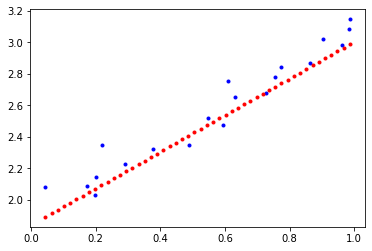

In [23]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [0]:
# Define the custom layers and model



#### Load the reuters dataset and define the class_names 

In [0]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [0]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

#### Get the dataset word index

In [0]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

In [0]:
# Print the first data example sentence



#### Preprocess the data

In [0]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

#### Define the loss function and optimizer



In [0]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [0]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [0]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

    
    
print("Duration :{:.3f}".format(time.time() - start_time))

#### Evaluate the model

In [0]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [0]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [0]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

#### Plot the learning curves

In [0]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [0]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [0]:
# Initialize a new model



#### Redefine the grad function using the @tf.function decorator

In [0]:
# Use the @tf.function decorator



#### Train the model

In [0]:
# Re-run the training loop



#### Print the autograph code

In [0]:
# Use tf.autograph.to_code to see the generated code

